# LBM Step 2: Registration

## Registration: Correct for rigid/non-rigid movement

- Apply the nonrigid motion correction (NoRMCorre) algorithm for motion correction.
- View pre/most correction movie
- Use quality metrics to evaluate registration quality

In [1]:
%gui qt
from pathlib import Path
import os
import numpy as np
import zarr
import pandas as pd
import napari

import logging
import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
from caiman.summary_images import correlation_pnr

import matplotlib.pyplot as plt


try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass

logging.basicConfig()

os.environ["QT_PLATFORM_PLUGIN"] = "xcb"
os.environ["CONDA_PREFIX_1"] = ""

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700
2024-09-10 15:04:33.316796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 15:04:33.316829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 15:04:33.317185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 15:04:33.320356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations

## Logging

In [ ]:
# set up logging
debug = True

logger = logging.getLogger("caiman")
logger.setLevel(logging.WARNING)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

# set env variables 
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

if debug:
   logging.getLogger("caiman").setLevel(logging.DEBUG)

### data path setup

In [2]:
raw_data_path = Path().home() / "caiman_data_org"
movie_path = raw_data_path / 'animal_01' / "session_01" / 'plane_1.zarr'
movie = zarr.open(movie_path)['mov']

pd.options.display.max_colwidth = 120

movie.info

## (optional): View hardware information

In [20]:
# !pip install cloudmesh-cmd5
!cms help # dont forget to call it after the install as it sets some defaults
!cms sysinfo

Sourcing .zshenv...
zsh:1: command not found: cms
Sourcing .zshenv...
zsh:1: command not found: cms


## User input: input data path and plane number

the same path as [pre_processing](./pre_processing.ipynb)
parent_dir = Path().home() / 'caiman_data' / 'animal_01' / 'session_01'

In [3]:
batch_path = raw_data_path / 'batch.pickle'
mc.set_parent_raw_data_path(str(movie_path))

PosixPath('/home/mbo/caiman_data_org/animal_01/session_01/plane_1.zarr')

In [4]:
# create a new batch
try:
    df = mc.load_batch(batch_path)
except (IsADirectoryError, FileNotFoundError):
    df = mc.create_batch(batch_path)

df=df.caiman.reload_from_disk()
df


,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
1,cnmf,caiman_phys,247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_fr...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': 'bee3b92b-c567-4c7c-bb29-d460e08fa980/bee3b92b-c567-4c7c-bb29-d460e08fa980_mean_projection....,2024-09-10T12:50:48,2024-09-10T12:52:31,98.29 sec,None,bee3b92b-c567-4c7c-bb29-d460e08fa980


In [19]:
## Correct filenames
for idx, row in df.iterrows():
    row.input_movie_path = Path(row.input_movie_path).with_suffix('.zarr')
df.caiman.save_to_disk()

In [5]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
1,cnmf,caiman_phys,247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_fr...,"{'main': {'fr': 9.62, 'dxy': (1.0, 1.0), 'decay_time': 0.4, 'strides': (48, 48), 'overlaps': (24, 24), 'max_shifts':...",{'mean-projection-path': 'bee3b92b-c567-4c7c-bb29-d460e08fa980/bee3b92b-c567-4c7c-bb29-d460e08fa980_mean_projection....,2024-09-10T12:50:48,2024-09-10T12:52:31,98.29 sec,None,bee3b92b-c567-4c7c-bb29-d460e08fa980


In [22]:
# df.iloc[0].caiman.run()
for i in [1, 2]:
    df.iloc[i].caiman.run()

/home/mbo/caiman_data_org/aab79e23-ebcc-45cb-a12b-6f7e3eae935c.runfile


2024-09-10 09:56:29.739346: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 09:56:29.739377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 09:56:29.739732: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 09:56:29.742479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/plane_1.zarr
mov
/home/mbo/caiman_data_org/animal_01/session_01/plane_1.zarr
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image

/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02.runfile
starting mc
MotionCorrect() called.
/home/mbo/caiman_data_org/animal_01/session_01/plane_1.zarr
mov
/home/mbo/caiman_data_org/animal_01/session_01/plane_1.zarr
mov
mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image



2024-09-10 09:57:16.060074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 09:57:16.060118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 09:57:16.060577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 09:57:16.064468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
The local backend is an alias for t

In [11]:
import napari
viewer = napari.Viewer()
# napari.view_image(df.iloc[0].mcorr.get_output()[::2, ...])
viewer.add_image(df.iloc[2].mcorr.get_output()[::2, ...], name='registered')
viewer.add_image(raw_movie, name='raw')

<Image layer 'raw' at 0x7f453c28b090>

# Registration parameters 

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

In [44]:
rows_keep = [df.iloc[n].uuid for n in [0,1]]
for i, row in df.iterrows():
    if row.uuid not in rows_keep:
        df.caiman.remove_item(row.uuid)


df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",None,2024-09-09T14:50:33,None,None,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",None,2024-09-09T14:50:49,None,None,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c


# Registration parameters 

The parameters are passed **directly** to `caiman`, this means you need to use the same exact names for the parameters and you can use all the parameters that you can use with `caiman` - because it's just passing them to `caiman`.

The parameters dict for a mesmerize batch item must have the following structure. Put all the parameters in a dict under a key called **main**. The **main** dict is then fed directly to `caiman`.

```python
{"main": {... params directly passed to caiman}}
```

In [12]:
pix_res = 1

mx = 10/pix_res             
max_shifts = (int(mx), int(mx))       # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
max_deviation_rigid = 3               # maximum deviation allowed for patch with respect to rigid shifts
pw_rigid = True                # flag for performing rigid or piecewise rigid motion correction
shifts_opencv = True        # flag for correcting motion using bicubic interpolation (otherwise FFT interpolation is used)
border_nan = 'copy'                   # replicate values along the boundary (if True, fill in with NaN)

mcorr_params = {
    'main':  # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'var_name_hdf5': 'mov',
        'max_shifts': max_shifts,
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan':border_nan,
        'pw_rigid': pw_rigid,
        'gSig_filt': None
    },
}

# # Add a "batch item" to the DataFrame this is the combination of:
# * algorithm to run, `algo`
# * input movie to run the algorithm on, `input_movie_path`
# * parameters for the specified algorithm, `params`
# * a name for you to keep track of things, usually the same as the movie filename, `item_name`
df.caiman.add_item(
    algo='mcorr',
    input_movie_path=movie_path,
    params=mcorr_params,
    item_name=movie_path.stem,  # filename of the movie, but can be anything
)

In [47]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",None,2024-09-09T14:50:33,None,None,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",None,2024-09-09T14:50:49,None,None,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c
2,mcorr,plane_1,animal_01/session_01/plane_1,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",None,2024-09-09T14:55:09,None,None,None,247620be-d14b-46da-b6ba-6c73bf607b02


## run registration for a single set of parameters

Technical notes: On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel.

In [48]:
df.iloc[0].caiman.run()

2024-09-09 14:55:21.656165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-09 14:55:21.656193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-09 14:55:21.656517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


mc failed, stored traceback in output


<Popen: returncode: 0 args: '/home/mbo/caiman_data_org/5ed9532f-a5d9-4ecb-bd...>

In [ ]:
corr, pnr = correlation_pnr(mcorr_movie, swap_dim=False)

In [17]:
import napari
napari.view_image(df.iloc[0].mcorr.get_output()[::4, ...])
napari.current_viewer().add_image(df.iloc[1].mcorr.get_output()[::4, ...])
napari.current_viewer().add_image(df.iloc[2].mcorr.get_output()[::4, ...])

IndexError: single positional indexer is out-of-bounds

# Registration Grid Search

More runs with varying parameters, stored on disk in the dataframe batch.pickle

In [33]:
# copy the mcorr_params2 dict to make some changes

# some variants of max_shifts
for shifts in [2,32]: 
    for strides in [12,64]:
        overlaps = int(strides / 2)
        # deep copy is the safest way to copy dicts
        new_params = deepcopy(mcorr_params)

        # assign the "max_shifts"
        new_params["main"]["max_shifts"] = (shifts, shifts)
        new_params["main"]["strides"] = (strides, strides)
        new_params["main"]["overlaps"] = (overlaps, overlaps)
        new_params['main']['var_name_hdf5'] = 'plane_2'
        df.caiman.add_item(
          algo='mcorr',
          item_name=movie_path.stem,
          input_movie_path=movie_path,
          params=new_params
        )
            
df.caiman.reload_from_disk()

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",None,2024-09-06T00:19:51,None,None,None,9781250d-22cb-4ebc-9de1-ad97e101ddee
1,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",None,2024-09-06T00:19:51,None,None,None,5ffcad60-5506-4243-936c-f8473ff4ab50
2,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",None,2024-09-06T00:19:51,None,None,None,0a463c4f-985d-47a4-9e95-cf776d98a1a3
3,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",None,2024-09-06T00:19:51,None,None,None,8cb260f3-ced8-4433-b9bf-fd6116b20964


In [36]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip
        
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

2024-09-06 00:20:18.685635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 00:20:18.685664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 00:20:18.686059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


starting mc
plane_2
plane_2


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/summary_images.py:209: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


finished computing correlation image


2024-09-06 00:33:07.741165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 00:33:07.741197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 00:33:07.741594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


starting mc
plane_2
plane_2


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/summary_images.py:209: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


finished computing correlation image


2024-09-06 00:35:33.807009: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 00:35:33.807036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 00:35:33.807428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


starting mc
plane_2
plane_2


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/summary_images.py:209: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


finished computing correlation image


2024-09-06 00:48:23.362092: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 00:48:23.362126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 00:48:23.362527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


starting mc
plane_2
plane_2


mc finished successfully!
computing projections
Computing correlation image


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
/home/mbo/miniconda3/envs/mbo-caiman/lib/python3.11/site-packages/caiman/summary_images.py:209: RuntimeWarning: invalid value encountered in divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)
100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


finished computing correlation image



# Distinguishing parameter variants

We can see that there are many parameter variants, but it is not easy to see the differences in parameters between the rows that have the same `item_name`.

We can use the `caiman.get_params_diffs()` to see the unique parameters between rows with the same `item_name`

In [6]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name=df.iloc[0]["item_name"])
diffs

""
0


# Use the varients to organize results to run multiple batch items.

`df.iterrows()` iterates through rows and returns the numerical index and row for each iteration

In [21]:
subplot_names

['raw',
 'ix 0: max_sh: 2, str: 12, ove: 6',
 'ix 1: max_sh: 2, str: 64, ove: 32',
 'ix 2: max_sh: 32, str: 12, ove: 6',
 'ix 3: max_sh: 32, str: 64, ove: 32']

In [14]:
plane = df.iloc[2].params['main']['var_name_hdf5']

# first item is just the raw movie
movies = [zarr.open(movie_path)[plane]]
subplot_names = ["raw"]

means = [df.iloc[0].caiman.get_projection("mean")]

# get the param diffs to set plot titles
param_diffs = df.caiman.get_params_diffs("mcorr", item_name=df.iloc[0]["item_name"])

# add all the mcorr outputs to the list
for i, row in df.iterrows():

    if row.algo != 'mcorr':
        continue

    # add to the list of movies to plot
    movies.append(row.mcorr.get_output())

    max_shifts = param_diffs.iloc[i]["max_shifts"][0]
    strides = param_diffs.iloc[i]["strides"][0]
    overlaps = param_diffs.iloc[i]["overlaps"][0]
    
    # subplot title to show dataframe index
    subplot_names.append(f"ix {i}: max_sh: {max_shifts}, str: {strides}, ove: {overlaps}")
    
    # mean images which we'll use later
    means.append(row.caiman.get_projection("mean"))

mcorr
mcorr
mcorr
mcorr


In [23]:
napari.view_image(movies[0], name=subplot_names[0])

# mcorr_movie = df.iloc[0].mcorr.get_output()
# mcorr_movie2 = df.iloc[-1].mcorr.get_output()
# corr, pnr = correlation_pnr(mcorr_movie, swap_dim=False)
# corr2, pnr2 = correlation_pnr(mcorr_movie2, swap_dim=False)

Viewer(camera=Camera(center=(0.0, 299.5, 279.5), zoom=1.3079464285714284, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(864.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=1729.0, step=1.0), RangeTuple(start=0.0, stop=599.0, step=1.0), RangeTuple(start=0.0, stop=559.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(864.0, 299.0, 279.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'raw' at 0x7f202c877f50>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f22ca409d

In [47]:
import napari
viewer = napari.Viewer()
viewer.add_image(mcorr_movie, name=f'plane_2_a')
viewer.add_image(mcorr_movie2, name=f'plane_2_b')
viewer.add_image(corr, name="Mean Correlation")
viewer.add_image(corr2, name="Mean Correlation2")

<Image layer 'Mean Correlation2' at 0x7fe77fe5cad0>

## Correlation metrics

Create a couple of summary images of the movie, including:
- maximum projection (the maximum value of each pixel) 
- correlation image (how correlated each pixel is with its neighbors)

If a pixel comes from an active neural component it will tend to be highly correlated with its neighbors.

In [ ]:
row_index = i

mean_proj = df.iloc[i].caiman.get_projection("mean")
max_proj = df.iloc[i].caiman.get_projection("max")
std_proj = df.iloc[i].caiman.get_projection("std")
corr_image = df.iloc[i].caiman.get_corr_image()
# viewer.add_image(mcorr_movie, rgb=False, multiscale=False)
# viewer.add_image(input_movie['plane_1'], rgb=False, multiscale=False)

viewer = napari.Viewer()
viewer.add_image(mean_proj)
viewer.add_image(std_proj)
viewer.add_image(max_proj)
viewer.add_image(corr_image)

## Pixel Shifts

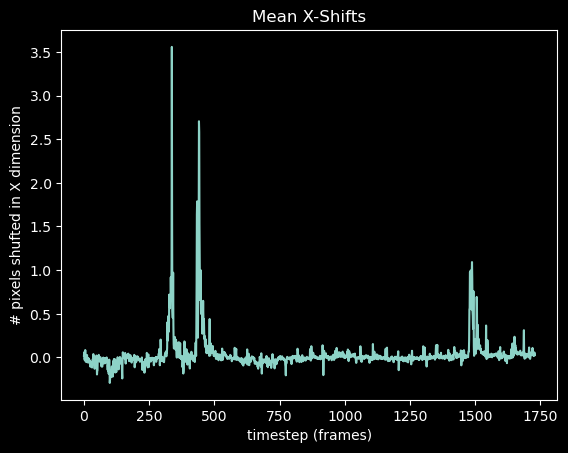

In [15]:
row_idx = 0

shifts = df.iloc[row_idx].mcorr.get_shifts()
shifts = shifts[1]
shiftsx = [x[0] for x in shifts]
shiftsy = [x[1] for x in shifts]
shiftsx_mean = [np.mean(x) for x in shiftsx]
shiftsy_mean = [np.mean(y) for y in shiftsy]
#%%
xr = list(range(1730))
plt.plot(xr, shiftsx_mean)
plt.title('Mean X-Shifts') # TODO: std error bars, napari layer
plt.xlabel("timestep (frames)")
plt.ylabel("# pixels shufted in X dimension")
plt.show()

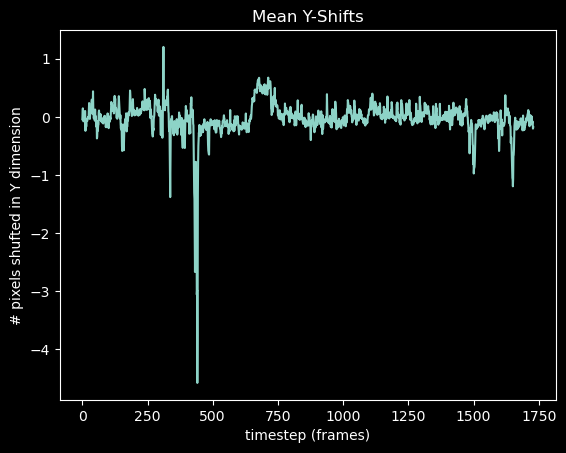

In [16]:
xr = list(range(1730))

plt.title('Mean Y-Shifts') # TODO: std error bars, napari layer
plt.xlabel("timestep (frames)")
plt.ylabel("# pixels shufted in Y dimension")
plt.plot(xr, shiftsy_mean)

# Optional, cleanup DataFrame

Use the index that works best and all other items.

Remove batch items (i.e. rows) using `df.caiman.remove_item(<item_uuid>)`. This also cleans up the output data in the batch directory.

**Note:** On windows calling `remove_item()` will raise a `PermissionError` if you have the memmap file open. The workaround is to shutdown the current kernel and then use `df.caiman.remove_item()`. For example, you can keep another notebook that you use just for cleaning unwanted mcorr items.

There is currently no way to close a `numpy.memmap`: https://github.com/numpy/numpy/issues/13510

Indices are always reset when you use `caiman.remove_item()`. UUIDs are always preserved.

In [14]:
df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2/5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2_mean_projection....,2024-09-09T14:50:33,2024-09-10T09:55:53,42.42 sec,None,5ed9532f-a5d9-4ecb-bdae-f14b37fc2ef2
1,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': 'aab79e23-ebcc-45cb-a12b-6f7e3eae935c/aab79e23-ebcc-45cb-a12b-6f7e3eae935c_mean_projection....,2024-09-09T14:50:49,2024-09-10T09:57:13,42.87 sec,None,aab79e23-ebcc-45cb-a12b-6f7e3eae935c
2,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02
3,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T10:46:06,None,None,None,00dc740c-7cf4-4cbb-b239-4cd8fc0439a2
4,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': [48, 48], 'overlaps': [24, 24], 'max_deviation_...",None,2024-09-10T11:05:25,None,None,None,0b04ece1-0bf1-4d76-8688-f4091e06ca2b


In [15]:
rows_keep = [2]
for i, row in df.iterrows():
    if i not in rows_keep:
        df.caiman.remove_item(row.uuid, safe_removal=False)
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,plane_1,animal_01/session_01/plane_1.zarr,"{'main': {'var_name_hdf5': 'mov', 'max_shifts': (10, 10), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_...",{'mean-projection-path': '247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02_mean_projection....,2024-09-09T14:55:09,2024-09-10T09:57:59,42.13 sec,None,247620be-d14b-46da-b6ba-6c73bf607b02


In [16]:
df.caiman.save_to_disk()

Name,/mov
Type,zarr.core.Array
Data type,float64
Shape,"(1730, 584, 544)"
Chunk shape,"(52, 584, 544)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4396912640 (4.1G)
No. bytes stored,1118784685 (1.0G)


## Evaluate Results: Optical Flow

In [20]:
import caiman as cm 

In [61]:
# fnames = [df.iloc[0].mcorr.get_]
# fnames = [str(df.iloc[0].mcorr.get_output_path())]
fnames = str(movie_path)
fnames_rig = str(df.iloc[0].mcorr.get_output_path())

#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(movie[1,:,:].shape, 2 * 2) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

In [27]:
%%capture

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fnames[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)


In [30]:
tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    fnames_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

# tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
#     mc.fname_tot_els[0], final_size[0], final_size[1],
#     swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [62]:
fpath = cm.paths.fname_derived_presuffix(str(fnames), 'metrics', swapsuffix='npz')
fpath

'/home/mbo/caiman_data_org/animal_01/session_01/plane_1_metrics.npz'

ERROR:caiman:File request:[/home/mbo/caiman_data_org/animal_01/session_01/plane_1.tif] not found!
ERROR:caiman:File request:[/home/mbo/caiman_data_org/animal_01/session_01/plane_1.tif] not found!
ERROR:caiman:File request:[/home/mbo/caiman_data_org/animal_01/session_01/plane_1.hdf5] not found!


fl
310.5013+/-271.0535 ; 64283.043 ; 20.12381097196258


ERROR:caiman:File request:[/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_frames_1730.tif] not found!
ERROR:caiman:File request:[/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_frames_1730.tif] not found!
ERROR:caiman:File request:[/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_frames_1730.hdf5] not found!
ERROR:caiman:File request:[/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_frames_1730.zarr] not found!


fl
198.30135+/-124.77118 ; 66929.35 ; 21.04290877918084
/home/mbo/caiman_data_org/247620be-d14b-46da-b6ba-6c73bf607b02/247620be-d14b-46da-b6ba-6c73bf607b02-plane_1_els__d1_584_d2_544_d3_1_order_F_frames_1730.zarr


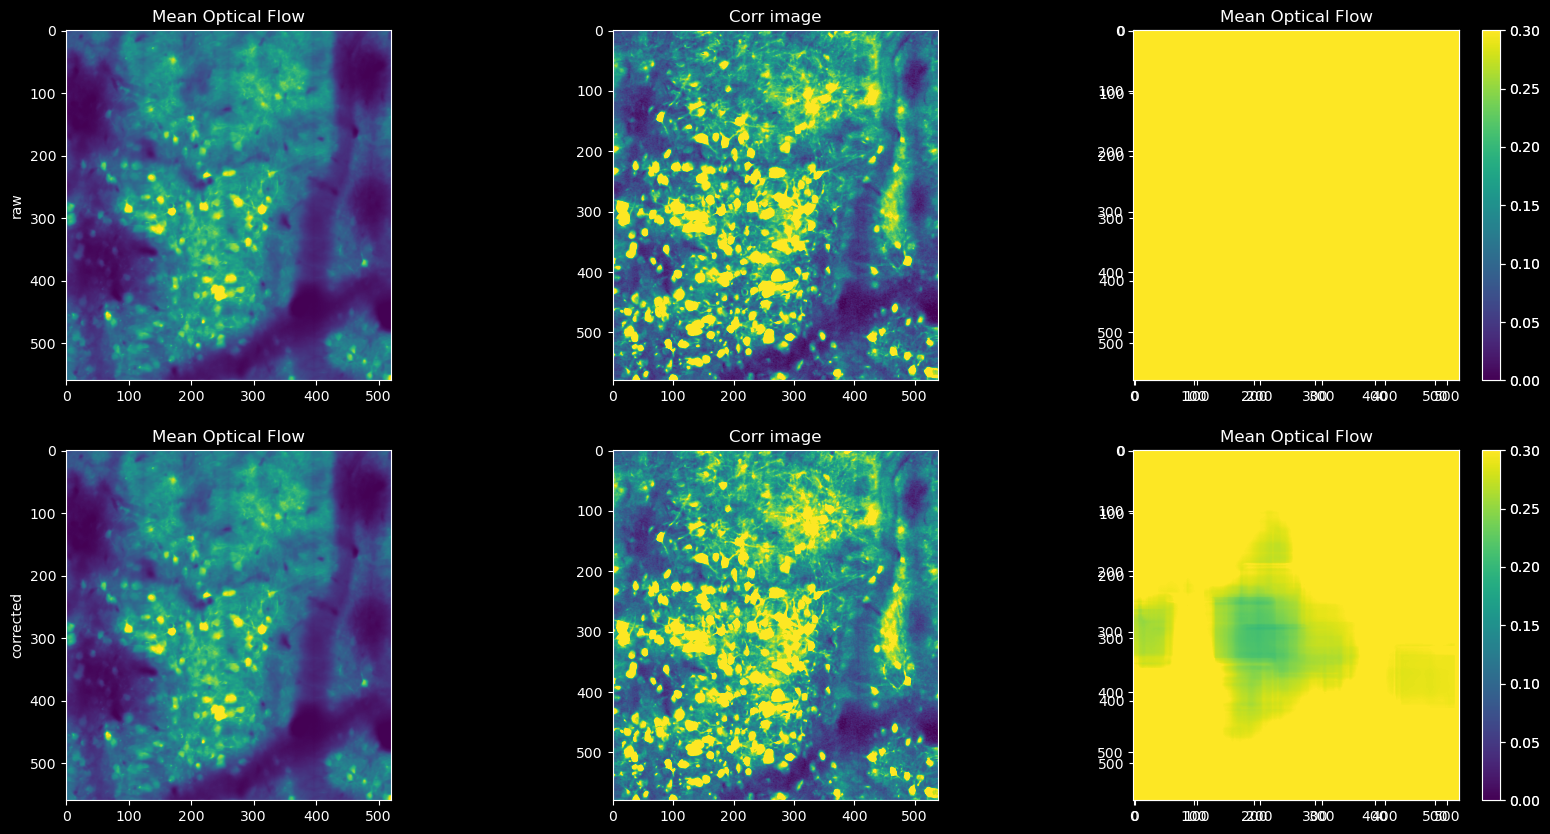

In [68]:
##%% plot the results of Residual Optical Flow
fls = [cm.paths.fname_derived_presuffix(str(fnames), 'metrics', swapsuffix='npz'), cm.paths.fname_derived_presuffix(str(fnames_rig), 'metrics', swapsuffix='npz')]

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)), fls, ['raw','corrected',]):
    print('fl')
    if Path(fl).suffix == '.npz':
        with np.load(str(fl)) as ld:
            print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
                ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
            plt.subplot(len(fls), 3, 1 + 3 * cnt)
            plt.ylabel(metr)
            try:
                mean_img = np.mean(cm.load(fl[:-12] + '.tif'))[12:-12, 12:-12]
            except:
                try:
                    mean_img = np.mean(
                        cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
                except:
                    try:
                        mean_img = np.mean(
                            cm.load(fl[:-12] + '.hdf5'), 0)[12:-12, 12:-12]
                    except:
                        try:
                            mean_img = np.mean(cm.load(fl[:-12] + '.zarr'), 0)[12:-12, 12:-12]
                        except:
                            print(fl[:-12] + '.zarr')

                    
                        
            lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
            plt.imshow(mean_img, vmin=lq, vmax=hq)
            plt.title('Mean Optical Flow')
            plt.subplot(len(fls), 3, 3 * cnt + 2)
            plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
            plt.title('Corr image')
            plt.subplot(len(fls), 3, 3 * cnt + 3)
            flows = ld['flows']
            plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
            plt.colorbar()
                    
                        
            lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
            plt.imshow(mean_img, vmin=lq, vmax=hq)
            plt.title('Mean Optical Flow')
            plt.subplot(len(fls), 3, 3 * cnt + 2)
            plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
            plt.title('Corr image')
            plt.subplot(len(fls), 3, 3 * cnt + 3)
            flows = ld['flows']
            plt.imshow(np.mean(
            np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
            plt.colorbar()

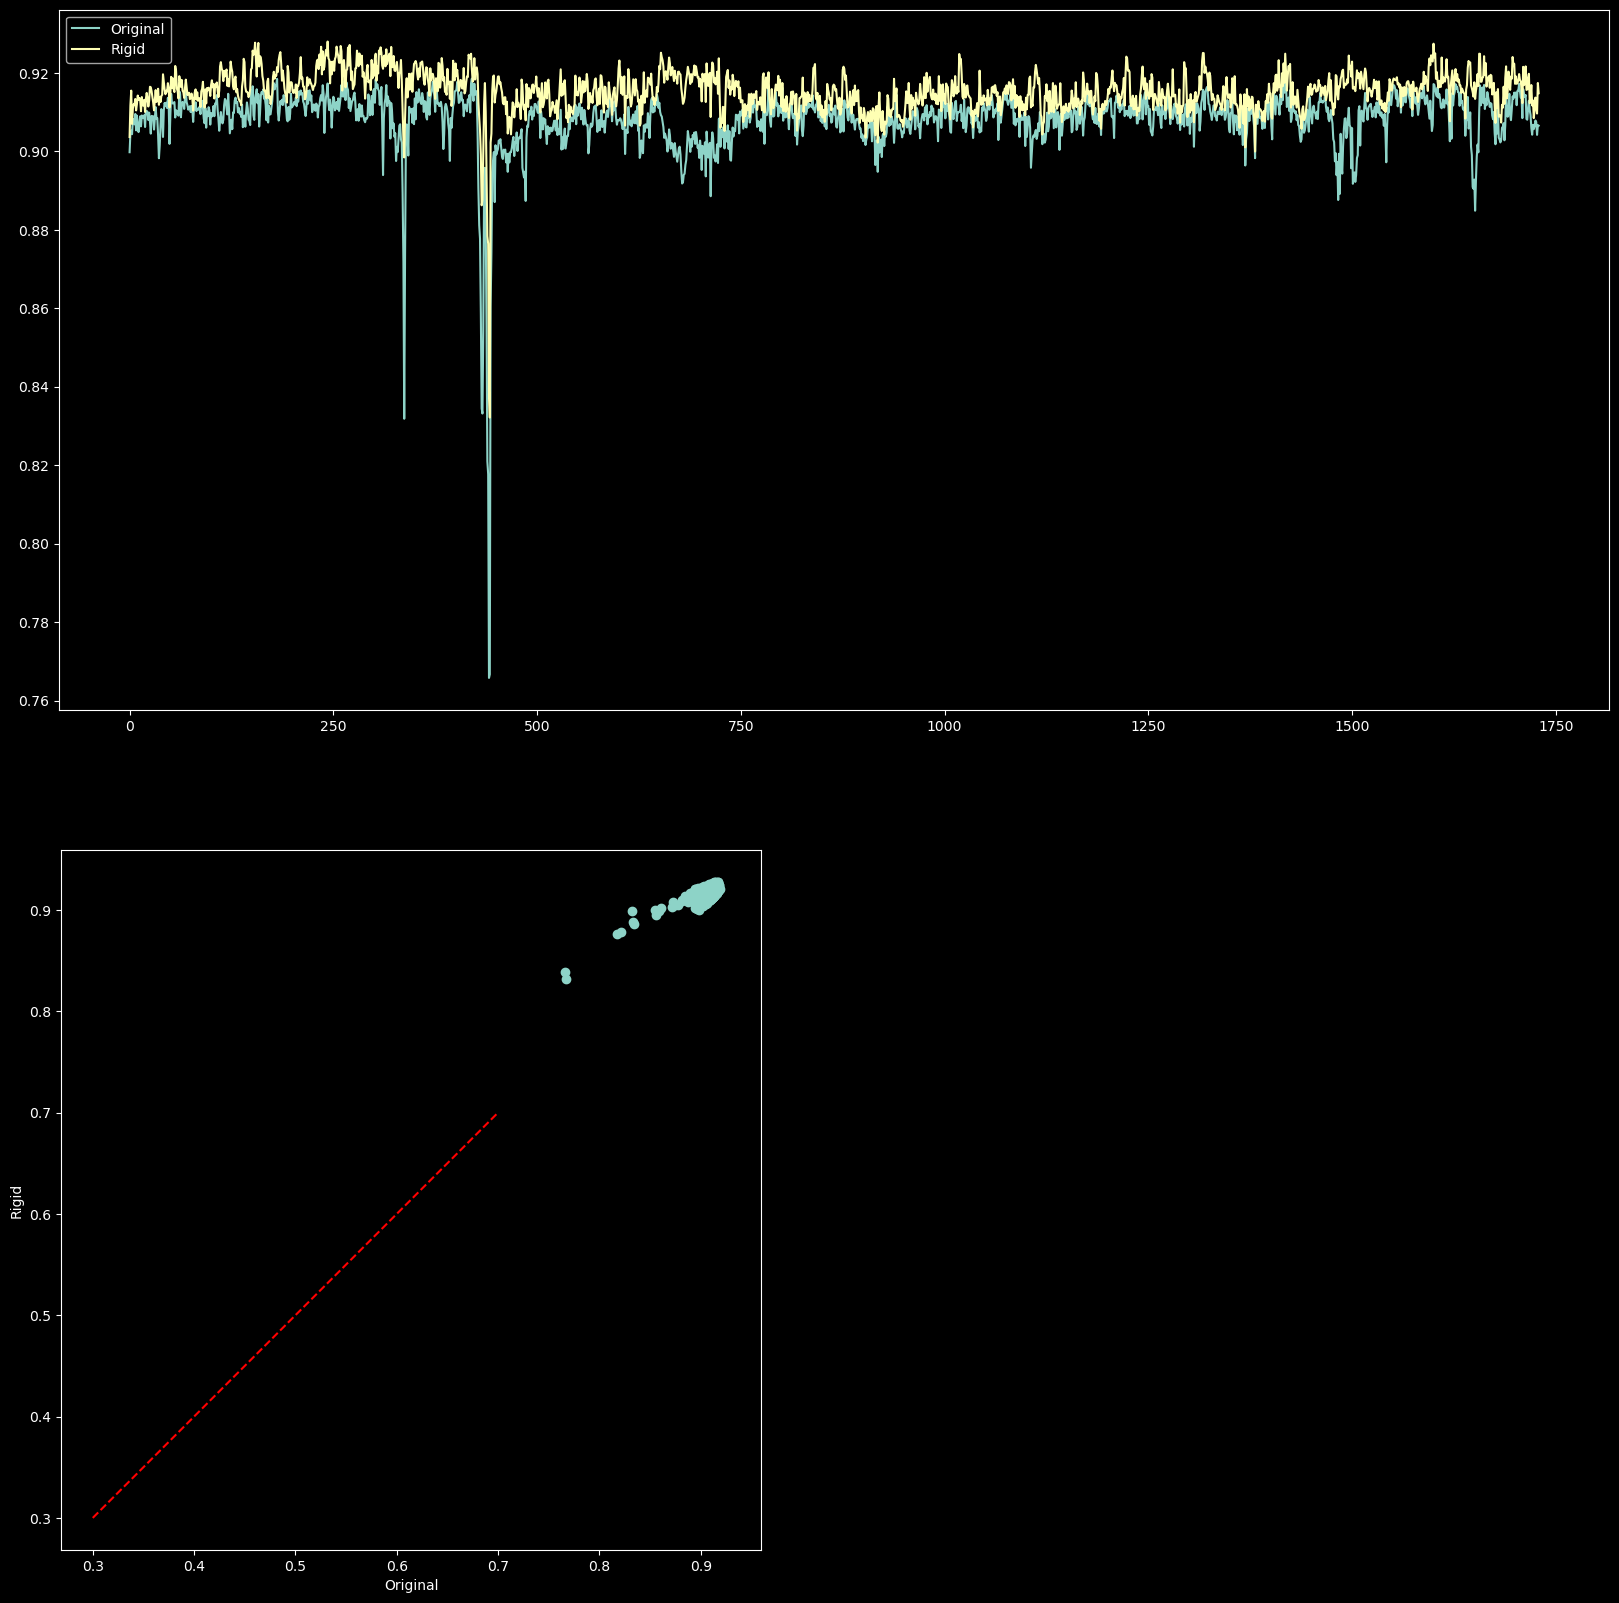

In [71]:
plt.figure(figsize = (20,20))
plt.subplot(211); plt.plot(correlations_orig); plt.plot(correlations_rig); 
plt.legend(['Original','Rigid','PW-Rigid'])
plt.subplot(223); plt.scatter(correlations_orig, correlations_rig); plt.xlabel('Original'); 
plt.ylabel('Rigid'); plt.plot([0.3,0.7],[0.3,0.7],'r--')
axes = plt.gca(); axes.set_xlim([0.3,0.7]); axes.set_ylim([0.3,0.7]); plt.axis('square');